In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nilearn as nl
import nibabel as nib

# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard




np.set_printoptions(precision=3, suppress=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
"""
Label definition and required parameters
"""
SEGMENT_CLASSES = {
0 : 'No Tumor',
1 : 'Necrotic/Nuclear', #Tumor Nucleus
2 : 'Edema',#Edema Part
3 : 'Expanding Tumor' #Expanding Tumor Part
}

IMG_SIZE=128


VOLUME_SLICES = 100
VOLUME_START_AT = 22 

In [5]:
# Verilerin ön incelenmesi ve görselleştirilmesi
TRAIN_DATASET_PATH = '/kaggle/input/bratsparts/Part1_Training'
VALIDATION_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'


In [6]:
"""Bu kod, böbrek ve beyin tümörlerinin segmentasyonu için Dice katsayısı, doğruluk, duyarlılık ve özgüllük gibi değerlerin hesaplanmasını sağlar.
dice_coef fonksiyonu, verilen gerçek ve tahmini etiketler arasında Dice katsayısını hesaplar ve döndürür. 
dice_coef_necrotic, dice_coef_edema ve dice_coef_enhancing fonksiyonları ise sırasıyla nekrotik, ödemli ve genişleyen tümör bölgeleri için 
Dice katsayısını hesaplar.precision fonksiyonu, verilen gerçek ve tahmini etiketler arasında doğruluk değerini hesaplar ve döndürür.
sensitivity fonksiyonu, verilen gerçek etiketler ve tahmini etiketler arasında duyarlılık değerini hesaplar ve döndürür.
specificity fonksiyonu ise verilen gerçek etiketler ve tahmini etiketler arasında özgüllük değerini hesaplar ve döndürür."""

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
  
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [7]:
import os
os.listdir(TRAIN_DATASET_PATH)
os.listdir(VALIDATION_DATASET_PATH)

['BraTS20_Validation_084',
 'BraTS20_Validation_118',
 'BraTS20_Validation_111',
 'BraTS20_Validation_060',
 'BraTS20_Validation_034',
 'BraTS20_Validation_045',
 'BraTS20_Validation_027',
 'BraTS20_Validation_073',
 'BraTS20_Validation_014',
 'BraTS20_Validation_047',
 'BraTS20_Validation_096',
 'BraTS20_Validation_068',
 'BraTS20_Validation_090',
 'BraTS20_Validation_038',
 'BraTS20_Validation_017',
 'BraTS20_Validation_069',
 'BraTS20_Validation_071',
 'BraTS20_Validation_092',
 'BraTS20_Validation_015',
 'BraTS20_Validation_117',
 'BraTS20_Validation_004',
 'BraTS20_Validation_103',
 'BraTS20_Validation_035',
 'BraTS20_Validation_033',
 'BraTS20_Validation_021',
 'BraTS20_Validation_061',
 'BraTS20_Validation_079',
 'BraTS20_Validation_085',
 'BraTS20_Validation_112',
 'BraTS20_Validation_065',
 'BraTS20_Validation_037',
 'BraTS20_Validation_053',
 'BraTS20_Validation_005',
 'BraTS20_Validation_064',
 'BraTS20_Validation_091',
 'BraTS20_Validation_042',
 'BraTS20_Validation_078',
 

In [8]:
print(len(os.listdir(TRAIN_DATASET_PATH)))
print(len(os.listdir(VALIDATION_DATASET_PATH)))

123
127


In [9]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [10]:
""" Verilerin yüklenmesi"""

train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
        
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [11]:
""" (İsteğe bağlı data generator) Verilerimizin boyutu çok büyük olduğundan dolayı biz bu verilerin hepsini Ram'e almak istemedik. Altarnatif çözüm olarak 
Stanford Üniversitesinin 2 Hocası tarafından geliştirilen Data Generatörü projemize dahil ettik."""


class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii')
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii')
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Generate masks
        y[y==4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

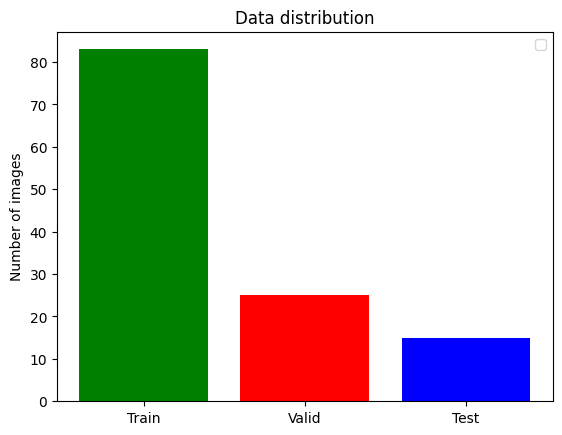

In [12]:
"""Veri setimizin dağılım grafiği"""

def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

In [14]:
""" modelin eğitim sırasında oluşan tüm değerleri tutar ve kaydeder.        egitim.log"""

csv_logger = CSVLogger('egitim.log', separator=',', append=False)

"""
During the training of the model, the code snippet creates two callbacks.

The first callback, CSVLogger, logs and saves all the values that are generated during the training process to a CSV file named 'egitim.log'. This can be used to analyze the training process later.

The second callback, ReduceLROnPlateau, modifies the learning rate of the model by a factor of 0.2 if there is no improvement in the validation loss for two consecutive epochs. This can speed up the learning process during training by changing the weight states related to the learning rate by 2 to 10 times faster than the normal training. This callback is called at the end of every epoch, and it tracks the validation loss as a parameter.

Both callbacks are passed to the fit method of the Keras model during training.
"""

callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

        csv_logger
    ]

In [15]:
#model fit
K.clear_session()

history =  model.fit(training_generator,
                     epochs=20,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )
model.save("u-net_part1.h5")

Epoch 1/20


2023-05-06 07:02:15.538782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 [==============================] - 83s 770ms/step - loss: 0.1641 - accuracy: 0.9750 - mean_io_u: 0.5386 - dice_coef: 0.2591 - precision: 0.9749 - sensitivity: 0.9615 - specificity: 0.9957 - dice_coef_necrotic: 0.0321 - dice_coef_edema: 0.1027 - dice_coef_enhancing: 0.0394 - val_loss: 0.0533 - val_accuracy: 0.9866 - val_mean_io_u: 0.6340 - val_dice_coef: 0.2804 - val_precision: 0.9866 - val_sensitivity: 0.9865 - val_specificity: 0.9955 - val_dice_coef_necrotic: 0.0549 - val_dice_coef_edema: 0.1756 - val_dice_coef_enhancing: 0.0496 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - 42s 505ms/step - loss: 0.0540 - accuracy: 0.9869 - mean_io_u: 0.6113 - dice_coef: 0.2964 - precision: 0.9896 - sensitivity: 0.9833 - specificity: 0.9965 - dice_coef_necrotic: 0.0909 - dice_coef_edema: 0.2378 - dice_coef_enhancing: 0.0881 - val_loss: 0.0400 - val_accuracy: 0.9866 - val_mean_io_u: 0.6501 - val_dice_coef: 0.3236 - val_precision: 0.9913 - val_sensitivity: 0.9857 - val_specifici

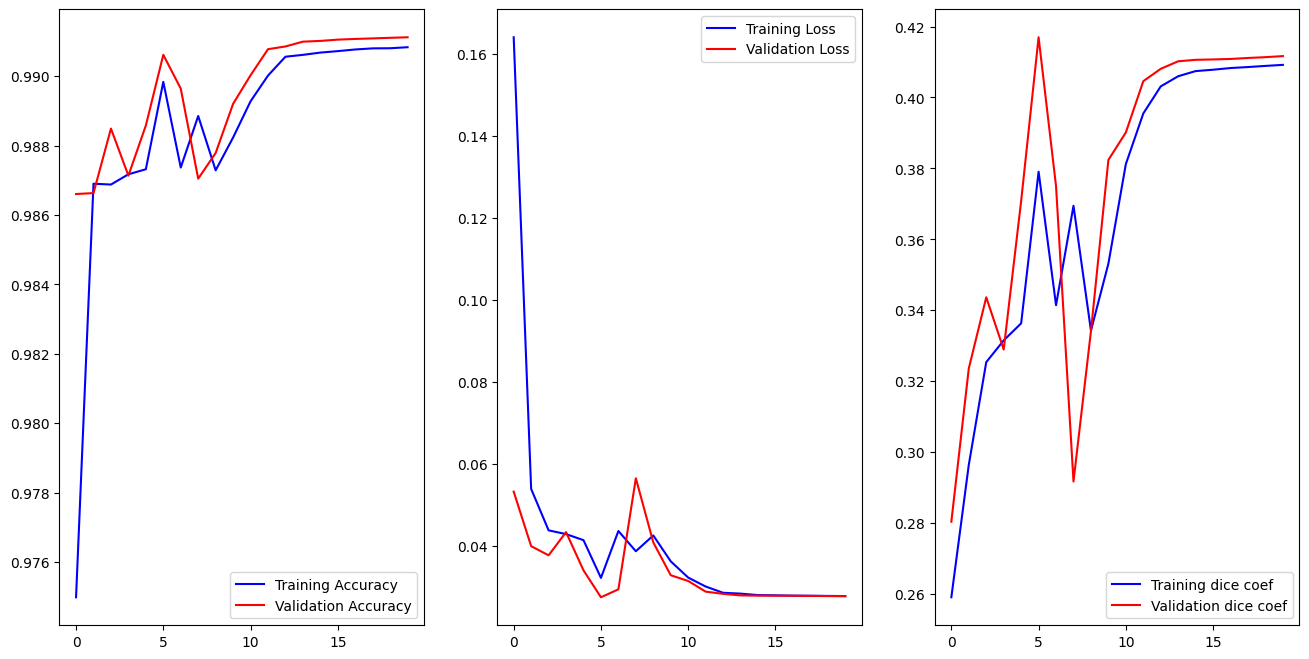

In [16]:
#Modelin yüklenmesi
#Modelin tahmin aşamasında kullanması için eğitim sonrası değerleri tekrar yükledik.
model = keras.models.load_model('/kaggle/working/u-net_part1.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

#Eğitim sonrası bize grafikleri verdi 
history = pd.read_csv('/kaggle/working/egitim.log', sep=',', engine='python')

hist=history



acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()


plt.show()

In [17]:
""" verilen mr tipleri bunlardan birisi olmalıdır         1) flair -- 2) t1-- 3) t1ce -- 4) -- t2  5) seg 
Girdi olarak verilen dosya tahmin edilebilir hale çeviriliyor"""
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_sizeVOLUME_SLICES,self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICESc,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICESc,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICESc] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

"""Bu fonksiyon, bir dizin yoludur, veri dosyalarının bulunduğu alt dizinlerin listesi ve yüklenen MRI görüntülerinin türü gibi argümanlar alır. 
Daha sonra, veri ve maske dosyalarını okur, yeniden boyutlandırır ve scans ve masks listelerine ekler. 
Bu listeler daha sonra numpy dizileri olarak döndürülür.Bunu da veriyi dizinden yüklemek için kullanıyoruz. """

def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/'+ mriType +'')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/seg*')[0] ) 
        
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')



In [19]:
"""Bu kod, eğitilmiş bir modeli kullanarak bir dizinde saklanan MRI taramaları üzerinde tahminler yapmaya yönelik görünüyor.
Önce nib.load fonksiyonunu kullanarak tarama verilerini yükler.
Daha sonra, cv2.resize kullanılarak taramalar yeniden boyutlandırılır ve X olarak adlandırılan 3D bir diziye kaydedilir. 
predictByPath fonksiyonu daha sonra modeli kullanarak X üzerinde tahminler yapar ve tahminleri bir dizi olarak döndürür.
showPredictsById fonksiyonu, modelin yaptığı tahminleri görselleştirmeyi amaçlı görünüyor. Bu fonksiyon, taramalar için ground truth verilerini yükler"""


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS19_2013_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS19_2013_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
  
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 60):
    path = f"/kaggle/input/bratsparts/Part1_Training/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS19_2013_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS19_2013_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case="5_1")#veri deneme


FileNotFoundError: No such file or no access: '/kaggle/input/bratsparts/Part1_Training/BraTS20_Training_5_1/BraTS19_2013_5_1_seg.nii'